<a href="https://colab.research.google.com/github/DanielDevito82/PhD-AI-Art-Histroy-Notebook/blob/main/Multi_Labelv%20-%20v.1.2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Preparations** 

## Definitation

Set the seeds for a reproducible results

In [27]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value) # tensorflow 2.x

Imports

In [37]:
#Imports
import sys
import cv2
import os
import random as rn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import tensorflow as tf
from PIL import Image
import itertools
from tensorboard import notebook

if 'google.colab' in str(get_ipython()):
  # cv2.imshow is deactivated in GoogleLab
  from google.colab.patches import cv2_imshow

# To identify the platform. For the platform individual operation: MAC or Windows
import platform

# for the storing of logs, h5, files...
from datetime import datetime

# to evaluate the predicted classification
from sklearn.metrics import (classification_report,
                             mean_absolute_error,
                             mean_squared_error,
                             mean_squared_log_error,
                             multilabel_confusion_matrix)

from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score)

#Note Tensorflow includes the Framework Keras at Version 2.0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, plot_model

# to force Tensporflow to use a single thread
from tensorflow.keras import backend # do I need this?

#EarlyStopping: Early stopping to track the val_loss and stop training once it begins increasing too much!
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D ,BatchNormalization, GlobalAveragePooling2D

In [38]:
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)

def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(5, 15))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

In [39]:
def displayImage(imgs):
  data = imgs[0].copy()
  if 'google.colab' in str(get_ipython()):
    cv2_imshow(data*255)
  else:
    cv2.imshow(data*255)
  #cv2_imshow(np.hstack(data[:3]))
  #plt.title(('Image')
  #plt.axis('off');
#  data.resize(g_Image_Shape[:2])
#  data = 255 * data
#  img = Image.fromarray(data)
#  print(type(img))
#  display(img.convert('RGB'))

Load the global variables








In [31]:
#GLOBAL VARIABLES
# an CNN needs an uniform width,height,channels
g_Image_Shape = (128,128,1) # my shape
g_Image_Shape_ResNet = (224,224,3) # ResNet
g_Image_Shape_InceptionV3 = (299,299,3) # InceptionV3
g_batch_size = 1

if 'google.colab' in str(get_ipython()):
  g_File_csv = '/content/drive/MyDrive/Colab Notebooks/features.csv'
  g_Folder_Trimed = '/content/drive/MyDrive/Colab Notebooks/_1'
else:
  g_File_csv = 'Image/features.csv'
  g_Folder_Trimed = 'Images/_trimed/_1'

split_validation = 0.2


Mount the drive

In [6]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


Config the Hardware

In [32]:
print(tf.__version__)
print(platform.system())

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
#try:
  #tf.config.experimental.set_memory_growth(physical_devices[0], True) # for a local enviroment, if your GPU memory should groth and not completely should be blocked. Because you need your GPu for other applications
#except:
  # Invalid device or cannot modify virtual devices once initialized.
#  pass

2.4.0
Linux
Num GPUs Available:  0


## Data Preprocessing

### Load and duplicate the data

In [40]:
# Read the data (Image, Labels ...)
init_df = pd.read_csv(g_File_csv,sep=';')

In [41]:
df = init_df.copy()
df_copy = []
for x in range(2):

  df = df.append(df_copy)
  df_copy = df.copy()

len(df)

420

In [42]:
# Extract the columns of the dataframe df for further preprocessing with the images
columns = []
for x  in df.columns:
    if x != 'image':
        columns.append(x)

In [43]:
# read how many layer / classes need to be defined in the last Dense Layer
lastLayer = len(columns)

In [44]:
#df.query('man==0')

In [45]:
#df.loc[df['man'] == 0]

### Generating the data

individual

In [46]:
#This functions helps if you are dealing with small datasets
image_gen = ImageDataGenerator(rotation_range=0.3, # rotate the image 30 degrees
                                   width_shift_range=0.10, # Shift the pic width by a max of 10%
                                   height_shift_range=0.10, # Shift the pic height by a max of 10%
                                   rescale=1/255, # Rescale the image by normalzing it.
                                   shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                                   zoom_range=0.2, # Zoom in by 20% max
                                   vertical_flip=True,
                                   horizontal_flip=True, # Allo horizontal flipping
                                   validation_split=split_validation, # Split the data into train and test/validation
                                   fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                  )

In [47]:
train_generator = image_gen.flow_from_dataframe(
                                               dataframe=df,
                                               directory=g_Folder_Trimed,
                                                color_mode='rgb',#'grayscale',                                          
                                                x_col="image",
                                               y_col=columns,
                                               batch_size=g_batch_size,
                                               seed=42,
                                               shuffle=False, # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                                               class_mode="raw",
                                               subset='training',
                                               target_size=g_Image_Shape[:2]
                                                )

Found 336 validated image filenames.


In [48]:
valid_generator=image_gen.flow_from_dataframe(
                                               dataframe=df,
                                               directory=g_Folder_Trimed,
                                                color_mode='rgb',#'grayscale', 
                                               x_col="image",
                                               y_col=columns,
                                               batch_size=g_batch_size,
                                               seed=42,
                                               shuffle=False, # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                                               class_mode="raw",
                                               subset='validation',
                                               target_size=g_Image_Shape[:2]
                                               )

Found 84 validated image filenames.


For the RESNET v2 model

In [69]:
train_batches_resnet_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
                                             vertical_flip=True,
                                             horizontal_flip=True,
                                             validation_split=split_validation) \
                .flow_from_dataframe(dataframe=df,
                      directory=g_Folder_Trimed,
                      color_mode='rgb',#'grayscale', 
                      x_col="image",
                      y_col=columns,
                      batch_size=g_batch_size,
                      seed=42,
                      shuffle=False,  # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                      class_mode="raw",
                      subset='training',
                      target_size=g_Image_Shape_ResNet[:2]
                      )   

Found 336 validated image filenames.


In [70]:
valid_batches_resnet_v2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,                  
                                             validation_split=split_validation) \
                .flow_from_dataframe(dataframe=df,
                      directory=g_Folder_Trimed,
                      color_mode='rgb',#'grayscale', 
                      x_col="image",
                      y_col=columns,
                      batch_size=g_batch_size,
                      seed=42,
                      shuffle=False, # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                      class_mode="raw",
                      subset='validation',
                      target_size=g_Image_Shape_ResNet[:2]
                      )   

Found 84 validated image filenames.


For the inception_v3 model

In [71]:
train_batches_inception_v3 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                                                vertical_flip=True,
                                                horizontal_flip=True,
                                                validation_split=split_validation) \
                .flow_from_dataframe(dataframe=df,
                      directory=g_Folder_Trimed,
                      color_mode='rgb',#'grayscale', 
                      x_col="image",
                      y_col=columns,
                      batch_size=g_batch_size,
                      seed=42,
                      shuffle=False,  # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                      class_mode="raw",
                      subset='training',
                      target_size=g_Image_Shape_InceptionV3[:2]
                      )   

Found 336 validated image filenames.


In [72]:
valid_batches_inception_v3 = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,                                               
                                                validation_split=split_validation) \
                .flow_from_dataframe(dataframe=df,
                      directory=g_Folder_Trimed,
                      color_mode='rgb',#'grayscale', 
                      x_col="image",
                      y_col=columns,
                      batch_size=g_batch_size,
                      seed=42,
                      shuffle=False, # to compare the preprocessing function & Validation or Test data shoundn't be shuffled
                      class_mode="raw",
                      subset='validation',
                      target_size=g_Image_Shape_InceptionV3[:2]
                      )   

Found 84 validated image filenames.


In [73]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_train

336

### Show the difference

In [75]:
imgs, labels = next(train_generator)
imgs_resnet_v2, labels_resnet_v2 = next(train_batches_resnet_v2)
imgs_inception_v3, labels_inception_v3 = next(train_batches_inception_v3)

In [76]:
imgs[0][0][0][0]
imgs[0][0][0].shape

(3,)

In [77]:
imgsApp[0][0][0]
labelsApp

NameError: ignored

In [ ]:
displayImage(imgs_resnet_v2)

In [ ]:
displayImage(imgs_inception_v3)

In [ ]:
displayImage(imgs)

## Monitoring

### Load Tensorboard

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d--%H%M")
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  notebook.list() # View open TensorBoard instances
  
  # Control TensorBoard display. If no port is provided, 
  # the most recently launched TensorBoard is used
  notebook.display(port=6006, height=1000)  
  # Load the TensorBoard notebook extension
  #%load_ext tensorboard

  %reload_ext tensorboard 
  %tensorboard --logdir logs

  log_directory = os.path.join("logs", timestamp)
else:
  print('Not running on CoLab')
  if platform.system() == 'Darwin' or platform.system() == 'Linux':
    # MACOS/LINUX: Use "logs\fit"
    log_directory = 'logs\fit'
  elif platform.system() == 'Windows':
    # WINDOWS: Use "logs\\fit"
    log_directory = 'logs\\fit'

  log_directory = log_directory + '\\' + timestamp


board = TensorBoard(log_dir=log_directory,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    update_freq='epoch',
                    profile_batch=1,
                    embeddings_freq=1)
  
 

## Create the models

### Class Models

In [75]:
class Models:
  def ResNet50V2_model(self,trainable,pretrained):
    print("def is " + inspect.stack()[0][3])
    
    if pretrained == False:
      #########################################
      #
      #
      #########################################
      model = tf.keras.applications.ResNet50V2(
                                      include_top=True, # the last layer is defined by classes and classifier_activation
                                      weights=None, 
                                      input_tensor=None,
                                      #input_shape=g_Image_Shape_ResNet, # only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) # NOT RELEVANT
                                      pooling=None, 
                                      classes=lastLayer, #...only to be specified if include_top is True, and if no weights argument is specified. # WORKING
                                      classifier_activation='sigmoid' #The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. # WORKING
                                  )

    elif pretrained == True:
      #########################################
      #
      #
      #########################################
      model = tf.keras.applications.ResNet50V2(
                                                  include_top=True, # the last layer will be defined in this if statment
                                                  weights='imagenet',
                                                  # input_tensor=None,                                               
                                                  input_shape=g_Image_Shape_ResNet,
                                                  pooling=None,
                                                  #classes=lastLayer, #...only to be specified if include_top is True, and if no weights argument is specified. # ERROR
                                                  #classifier_activation='sigmoid' #The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer.
                                                  ) 
      print(type(model))

      for layer in model.layers:
        layer.trainable = trainable

      avg = GlobalAveragePooling2D()(model.output)
      predictions = Dense(lastLayer, activation='sigmoid')(avg)
      model = Model(inputs=model.input, outputs=predictions)

    opt = Adam(learning_rate = 0.001, beta_1 = 0.9,
                beta_2 = 0.999, epsilon = 1e-07,
                amsgrad = False, name = 'Adam', clipvalue=1)

    # For a multi-label classification problems use binary_crossentropy
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

#  def myModel():
#    model = Sequential()

#  return model

  def Inception_v3_model(self,trainable,fineTuning):
    print("def is " + inspect.stack()[0][3])

    if pretrained == False:
      #########################################
      #
      #
      #########################################
      model = tf.keras.applications.InceptionV3(
                                        include_top=True, # the last layer is defined by classes and classifier_activation
                                        weights=None, 
                                        input_tensor=None,
                                        input_shape=g_Image_Shape_InceptionV3, 
                                        pooling=None, 
                                        classes=lastLayer,
                                        classifier_activation='sigmoid'
      )


    elif pretrained == True:
      #########################################
      #
      #
      #########################################
      original_model = tf.keras.applications.InceptionV3(
                                        # include_top=False, # the last layer is defined by classes and classifier_activation
                                        # weights='imagenet', 
                                        # input_tensor=None,
                                        # input_shape=g_Image_Shape_InceptionV3, 
                                        # pooling=None 
                                        #classes=lastLayer,
                                        #classifier_activation='sigmoid'
      )
      print(type(original_model))

      bottleneck_input  = original_model.get_layer(index=0).input
      print(bottleneck_input)
      bottleneck_output = original_model.get_layer(index=-2).output
      print(bottleneck_output)
      bottleneck_model  = Model(inputs=bottleneck_input, outputs=bottleneck_output)

      for layer in bottleneck_model.layers:
        layer.trainable = trainable

      model = Sequential()
      model.add(bottleneck_model)
      model.add(Dense(lastLayer, activation='sigmoid', input_dim=2048)) 
      #avg = GlobalAveragePooling2D()(model.output)
      #predictions = Dense(lastLayer, activation='sigmoid')(avg)
      #model = Model(inputs=model.input, outputs=predictions)

    opt = Adam(learning_rate = 0.005, beta_1 = 0.9,
                  beta_2 = 0.999, epsilon = 1e-07,
                  amsgrad = False, name = 'Adam', clipvalue=1)

    # For a multi-label classification problems use binary_crossentropy
    model.compile(optimizer=opt,
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    print(model.summary())

    return model

### read the class and create a model object

In [76]:
#model = Models().chest(g_Image_Shape,lastLayer)
#model = Models().myfirstModel(g_Image_Shape,lastLayer)

#model = Models().ResNet50V2_model(trainable=False,pretrained=False)
model = Models().Inception_v3_model(trainable=False,pretrained=True)

def is Inception_v3_model
96116736/96112376 [==============================] - 0s 0us/step
<class 'tensorflow.python.keras.engine.functional.Functional'>
KerasTensor(type_spec=TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [ ]:
#plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

### Early stop

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=2, patience=3)

# **Training**

### train the model

In [77]:
results = model.fit(train_batches_inception_v3,
                   epochs=20,
                   validation_data=valid_batches_inception_v3,
                   steps_per_epoch=step_size_train,
                   #callbacks=board,
                   #callbacks=early_stop,
                   #callbacks=[early_stop,board], # non Colab add board for TensorBoard
                   verbose=1
                   )


Epoch 1/20
336/336 [==============================] - 180s 522ms/step - loss: 0.7034 - accuracy: 0.3305 - val_loss: 0.7501 - val_accuracy: 0.5238
Epoch 2/20
336/336 [==============================] - 142s 423ms/step - loss: 0.3753 - accuracy: 0.2154 - val_loss: 1.2538 - val_accuracy: 0.3333
Epoch 3/20
336/336 [==============================] - 142s 422ms/step - loss: 0.2262 - accuracy: 0.3024 - val_loss: 0.5413 - val_accuracy: 0.3571
Epoch 4/20
336/336 [==============================] - 141s 420ms/step - loss: 0.2263 - accuracy: 0.2501 - val_loss: 1.5839 - val_accuracy: 0.4405
Epoch 5/20
336/336 [==============================] - 142s 422ms/step - loss: 0.3762 - accuracy: 0.2933 - val_loss: 0.5344 - val_accuracy: 0.4762
Epoch 6/20
336/336 [==============================] - 142s 423ms/step - loss: 0.1769 - accuracy: 0.3412 - val_loss: 0.9656 - val_accuracy: 0.3690
Epoch 7/20
336/336 [==============================] - 142s 423ms/step - loss: 0.2315 - accuracy: 0.3761 - val_loss: 0.3793 -

# **Validate the model**

In [78]:
metrics =  pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.572970,0.315476,0.750131,0.523810
1,0.409240,0.229167,1.253803,0.333333
2,0.292714,0.291667,0.541345,0.357143
3,0.289945,0.285714,1.583869,0.440476
4,0.342171,0.291667,0.534363,0.476190
5,0.269656,0.315476,0.965584,0.369048
6,0.211603,0.318452,0.379311,0.750000
7,0.279316,0.342262,0.448269,0.428571
8,0.216788,0.357143,0.327687,0.392857
9,0.176134,0.369048,1.041434,0.261905


In [79]:
#loss = Verlust in Traindata train_image_gen. Ziel: decrease | Model kennt Ergebnis in Train Data
#var_loss = Verlust in Testdata test_image_gen. Ziel: decrease  | Model kennt Ergebnis in Test Data 
#accuracy = Richtigkeit der Train data (train_image_gen). Ziel: increase
#val_accuracy = Richtigkeit der Test data (test_image_gen). Ziel: increase
#Overfitting = nicht vorhandene Muster im Datensatz erkennt | training data but does not perform well on the evaluation data | "loss" keeps decreasing (abnehmen) while "val_loss" is stale, or increases (zunehmen). 
#Unterfitting = keine relevanten Schlüsse | model is unable to capture the relationship between the input examples & the target values | "loss" and "val_loss" are to far away from each other
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.572970,0.315476,0.750131,0.523810
1,0.409240,0.229167,1.253803,0.333333
2,0.292714,0.291667,0.541345,0.357143
3,0.289945,0.285714,1.583869,0.440476
4,0.342171,0.291667,0.534363,0.476190
5,0.269656,0.315476,0.965584,0.369048
6,0.211603,0.318452,0.379311,0.750000
7,0.279316,0.342262,0.448269,0.428571
8,0.216788,0.357143,0.327687,0.392857
9,0.176134,0.369048,1.041434,0.261905


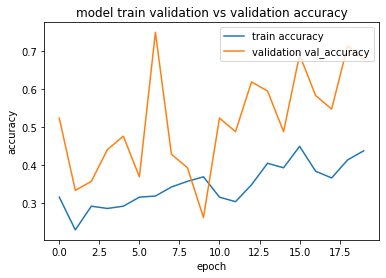

In [80]:
# plot train and validation loss
plt.plot(metrics[['accuracy']])
plt.plot(metrics[['val_accuracy']])
plt.title('model train validation vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation val_accuracy'], loc='upper right')
plt.show()

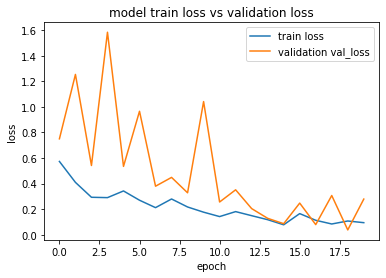

In [81]:
#metrics[['loss', 'val_loss']].plot()

# plot train and validation loss
plt.plot(metrics[['loss']])
plt.plot(metrics[['val_loss']])
plt.title('model train loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation val_loss'], loc='upper right')
plt.show()

In [87]:
#to get the last Epoch
model.evaluate(valid_batches_inception_v3)

84/84 [==============================] - 29s 340ms/step - loss: 0.2785 - accuracy: 0.6786


[0.2785104811191559, 0.6785714030265808]

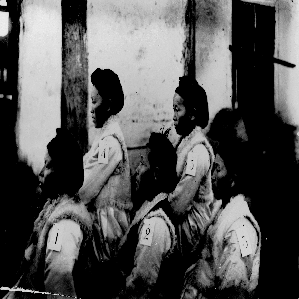

In [98]:
imgsApp, labelsApp = next(valid_batches_inception_v3)
displayImage(imgsApp)

In [99]:
pred = model.predict(imgsApp,verbose=1)
pred_bool = (pred > 0.5)
results=pd.DataFrame(pred_bool.astype(int), columns=columns)
results

1/1 [==============================] - 0s 223ms/step


,man,women,front,left,right
0,0,1,0,0,0


In [102]:
pred_probabilities=model.predict(valid_batches_inception_v3,verbose=1)
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras

84/84 [==============================] - 29s 337ms/step


In [103]:
#pred_probabilities

In [104]:
pred_bool = (pred_probabilities > 0.5)

In [105]:
predictions = pred_bool.astype(int)

In [106]:
results=pd.DataFrame(predictions, columns=columns)

In [107]:
results

,man,women,front,left,right
0,1,1,1,0,0
1,1,0,1,0,0
2,1,0,0,1,0
3,1,0,1,0,0
4,1,0,0,1,0
...,...,...,...,...,...
79,1,0,1,0,0
80,1,0,0,1,0
81,0,1,1,0,0
82,1,0,1,0,0


In [ ]:
#for _ in range(5):
#  img, label = next(valid_batches)
#  displayImage(img)

In [ ]:
img_iter_val_0, img_iter_val_1 = itertools.tee(valid_batches, 2)

In [ ]:
type(img_iter_val_0)

itertools._tee

In [ ]:
img_iter_val_1

In [100]:
y_true = np.vstack(next(valid_batches_inception_v3)[1] for _ in range(41)).astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [108]:
mcm = multilabel_confusion_matrix(y_true=y_true, y_pred=predictions[:41])

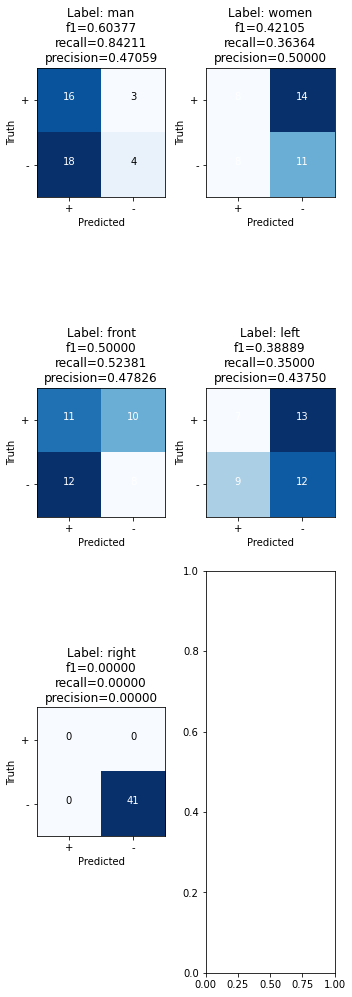

In [111]:
plot_multiclass_confusion_matrix(y_true, y_pred=predictions[:41], label_to_class=columns, save_plot=False)

In [ ]:
mcm

array([[[ 6, 13],
        [ 9, 13]],

       [[13,  9],
        [13,  6]],

       [[13,  7],
        [17,  4]],

       [[ 4, 17],
        [ 6, 14]],

       [[39,  2],
        [ 0,  0]]])